In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
from pyecharts.charts import Map
from pyecharts import options as opts
from pyecharts.charts import Bar,Pie,Scatter,HeatMap

import warnings
warnings.filterwarnings('ignore')

In [2]:
#导入数据“
data=pd.read_csv('./house.csv')

In [25]:
data['面积'][-3:]=data['面积'][-3:].apply(lambda x:x[:-2]+'米' if x[-2:]=='平米' else x)

In [26]:
data['面积'].tail()

30766       92平米
30767    136.7平米
30768    285.53米
30769     134.0米
30770       9.0米
Name: 面积, dtype: object

In [27]:
for index,mi in data['面积'].iloc[(data['面积'][-2:]!='平米').index].items():
    mianji=float(mi[:-2])*2
#     data['面积'].iloc[index]='{}平米'.format(mianji)
    data.at[index,'面积']='{}平米'.format(mianji)#速度快

In [182]:
data.drop_duplicates(inplace=True)

In [8]:
data.dropna(how='any',inplace=True)

In [9]:
data.产权.value_counts()

70年    26379
40年     3229
50年     1150
未知         7
Name: 产权, dtype: int64

In [10]:
data=data.loc[data['产权']!='未知']

In [16]:
#处理区域变量
data.区域.value_counts().sort_values(ascending=False).to_frame().head(15)

,区域
余杭临平,2084
临安临安,1715
余杭闲林,1683
余杭未来科技城,855
江干丁桥,787
余杭良渚,768
江干九堡,682
钱塘新区沿江南,639
萧山萧山新城区,619
西湖文三西路,582


In [17]:
def location(x):
    if '临安' in x : return '临安市'
    elif '上城' in x : return '上城区'
    elif '下城' in x :return '下城区'
    elif '江干' in x :return '江干区'
    elif '拱墅' in x :return '拱墅区'
    elif '西湖' in x :return '西湖区'
    elif '滨江' in x :return '滨江区'
    elif '萧山' in x :return '萧山区'
    elif '余杭' in x :return '余杭区'
    elif '富阳' in x :return '富阳区'
    elif '钱塘' in x :return '钱塘新区'
    else : return '其他'

In [18]:
data['地理位置']=data['区域'].apply(location)

In [30]:
#处理单价变量，去除单位,方法一
data.单价.apply(lambda x :str(x).split('/')[0][:-1]).astype('float')

0        21015.0
1        28416.0
2        17323.0
3        18249.0
4        24112.0
          ...   
30766    19566.0
30767    17557.0
30768    19613.0
30769    22314.0
30770    14946.0
Name: 单价, Length: 30758, dtype: float64

In [31]:
#方法二
data['单价']=data.单价.apply(lambda x:str(x)).str.findall('\d+').str[0].astype('float')

In [32]:
#处理年限变量
data.年限.value_counts()

未知年建/板楼        2083
2016年建/板楼      1895
2017年建/板楼      1421
2014年建/板楼      1375
2010年建/板楼      1340
               ... 
1996年建/暂无数据       1
1985年建/塔楼         1
1994年建/塔楼         1
1995年建/平房         1
1964年建/板楼         1
Name: 年限, Length: 143, dtype: int64

In [35]:
data['起建时间']=data['年限'].str.split('/').str[0]
data['建筑类型']=data['年限'].str.split('/').str[1]

In [37]:
data=data.loc[(data['起建时间']!='未知年建') & (data['建筑类型']!='暂无数据')]

In [46]:
import datetime
import time
year=time.strftime('%Y',time.localtime())

In [50]:
data['楼龄']=int(year)-data['起建时间'].str[:4].astype('int')#方法一

In [56]:
2020-data['起建时间'].str.extract('(\d+)').astype('int')

KeyError: '起建时间'

In [52]:
data.drop(['年限','起建时间'],axis=1,inplace=True)

In [55]:
#处理户型变量
#方法一
data['户型'].str[0].astype('int')#室数
data['户型'].str[2:3].astype('int')#厅数

0        2
1        2
2        2
3        2
4        2
        ..
30762    2
30765    2
30766    2
30768    2
30769    3
Name: 户型, Length: 27578, dtype: int64

In [64]:
#方法二
data['室数']=data['户型'].str.findall('(\d)室(\d)厅').str[0].str[0].astype('int')
data['厅数']=data['户型'].str.findall('(\d)室(\d)厅').str[0].str[1].astype('int')

In [66]:
#处理挂牌时间
data['挂牌时间']=pd.to_datetime(data['挂牌时间'])

In [68]:
data.set_index('挂牌时间',inplace=True)

In [69]:
#处理朝向变量
data.朝向.value_counts()

南         17143
南 北        5960
北           882
东           622
东南          593
          ...  
东 西南          1
东南 西          1
东 北 南         1
西 东北          1
东 南 西北        1
Name: 朝向, Length: 72, dtype: int64

In [71]:
def oriteration(x):
    if '东南' in x:
        if x.count('南')>1:
            return '南'
        else:
            return '东南'
    elif '西南' in x :
        if x.count('南')>1:
            return '南'
        else:
            return '西南'
    elif '南' in x :
        return '南'
    elif '东' in x:
        return '东'
    elif '西' in x:
        return '西'
    else:
        return '北'

In [73]:
data['朝向']=data['朝向'].apply(oriteration)

In [77]:
#处理楼层变量
data.shape[0]-data['楼层'].str.contains('/').sum()

15

In [79]:
data.楼层

挂牌时间
2019-06-12    低楼层/共33层
2019-04-04      联排/共3层
2018-09-07    高楼层/共33层
2018-08-15    中楼层/共33层
2019-04-21    高楼层/共34层
                ...   
2018-11-06     高楼层/共6层
2018-07-02    低楼层/共11层
2018-07-07    低楼层/共11层
2019-04-14      联排/共3层
2019-05-08         共3层
Name: 楼层, Length: 27578, dtype: object

In [85]:
data['楼层位置']=data['楼层'].str.split('/').str[0]
# data['层数']=data['楼层'].str.split('/').str[1].str.findall('\d+').str[0].astype('int')#ValueError: cannot convert float NaN to integer
data['层数']=data['楼层'].str.extract('(\d+)').astype('int')

In [88]:
data=data.loc[data['楼层位置'].isin(['高楼层','中楼层','低楼层'])]
data.drop('楼层',axis=1,inplace=True)

In [90]:
#处理装修情况
def decoration(x):
    if '精装' in x:
        return '精装'
    elif '简装' in x:
        return '简装'
    elif '毛坯' in x:
        return '毛坯'
    else:
        return '其他'

In [91]:
data['装修情况']=data['装修情况'].apply(decoration)

In [92]:
data=data.loc[data['装修情况']!='其他']

In [93]:
#处理面积变量
data.面积.value_counts()

89平米        823
87平米        113
88平米        109
138平米        91
139平米        77
           ... 
132.22平米      1
129.68平米      1
48.28平米       1
184.97平米      1
130.01平米      1
Name: 面积, Length: 9730, dtype: int64

In [99]:
data['面积']=data['面积'].str.extract('([\d,.]+)').astype('float')

In [102]:
#对变量排序
data.head(3)

,产权,关注,区域,单价,小区,总价/万元,户型,房屋编码,朝向,装修情况,面积,地理位置,建筑类型,楼龄,室数,厅数,楼层位置,层数
挂牌时间,,,,,,,,,,,,,,,,,,
2019-06-12,70年,0,余杭临平,21015.0,众安理想湾,210.0,3室2厅,103105013026,南,精装,99.93,余杭区,板楼,5,3,2,低楼层,33
2018-09-07,70年,2,余杭临平,17323.0,众安理想湾,220.0,3室2厅,103102855120,南,精装,127.00,余杭区,板楼,5,3,2,高楼层,33
2018-08-15,70年,4,余杭临平,18249.0,众安理想湾,250.0,3室2厅,103102737121,南,简装,137.00,余杭区,塔楼,5,3,2,中楼层,33


In [107]:
columns=['地理位置','区域','小区','总价/万元','单价','面积','楼龄','建筑类型','楼层位置','层数','装修情况','室数','厅数','朝向','产权','户型','关注']
data=pd.DataFrame(data,columns=columns)

In [109]:
data.head()

,地理位置,区域,小区,总价/万元,单价,面积,楼龄,建筑类型,楼层位置,层数,装修情况,室数,厅数,朝向,产权,户型,关注
挂牌时间,,,,,,,,,,,,,,,,,
2019-06-12,余杭区,余杭临平,众安理想湾,210.0,21015.0,99.93,5,板楼,低楼层,33,精装,3,2,南,70年,3室2厅,0
2018-09-07,余杭区,余杭临平,众安理想湾,220.0,17323.0,127.00,5,板楼,高楼层,33,精装,3,2,南,70年,3室2厅,2
2018-08-15,余杭区,余杭临平,众安理想湾,250.0,18249.0,137.00,5,塔楼,中楼层,33,简装,3,2,南,70年,3室2厅,4
2019-04-21,余杭区,余杭临平,众安理想湾,215.0,24112.0,89.17,5,板楼,高楼层,34,精装,3,2,南,70年,3室2厅,1
2019-06-03,余杭区,余杭临平,众安理想湾,220.0,24882.0,88.42,5,塔楼,低楼层,34,精装,3,2,南,70年,3室2厅,1


In [110]:
#处理异常值
data.describe()

,总价/万元,单价,面积,楼龄,层数,室数,厅数,关注
count,26767.000000,26767.000000,26767.000000,26767.000000,26767.000000,26767.000000,26767.000000,26767.000000
mean,345.994994,35733.526693,96.467640,12.245414,16.200994,2.588635,1.571973,17.586580
std,235.001958,13350.426993,46.047503,8.059150,9.274732,0.990002,0.556093,31.890993
min,35.000000,8807.000000,16.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,210.000000,25577.500000,63.365000,6.000000,7.000000,2.000000,1.000000,2.000000
50%,298.000000,34107.000000,88.680000,10.000000,16.000000,3.000000,2.000000,7.000000
75%,420.000000,43541.500000,123.000000,17.000000,23.000000,3.000000,2.000000,20.000000
max,7000.000000,141831.000000,1396.510000,56.000000,60.000000,9.000000,5.000000,904.000000


In [111]:
data=data.loc[(data['总价/万元']>50) & (data['总价/万元']<3000)]

In [112]:
data=data.loc[data['户型']!='0室0厅']

In [113]:
data.shape

(26726, 17)

In [114]:
#探索各变量间的相关性
corr=data.corr()

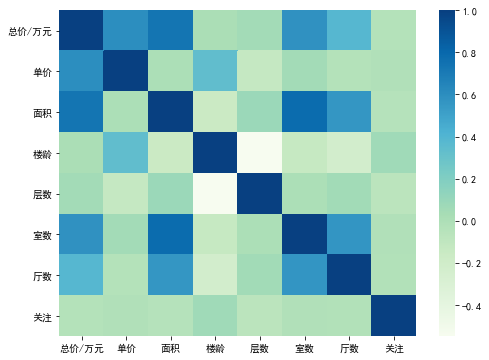

In [118]:
plt.figure(figsize=(8,6))
f=sns.heatmap(corr,cmap='GnBu')
picture1=f.get_figure()
picture1.savefig('杭州市个区房源的数量，总价，单价，关注度热度对比.png')
plt.show()

In [120]:
#杭州市各区房源数量对比
count_area=data.groupby('地理位置')['小区'].count().sort_values(ascending=False).reset_index()

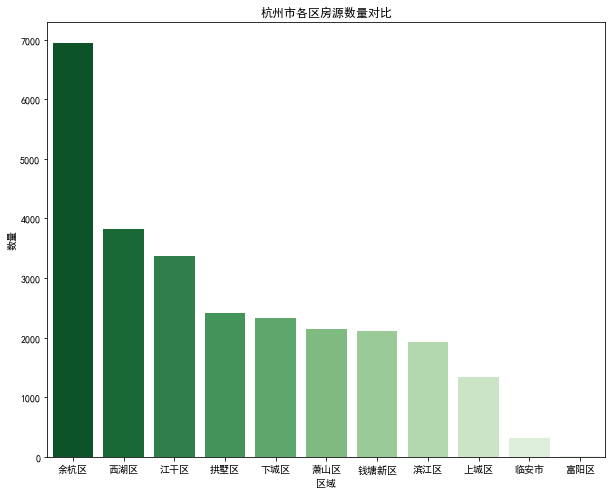

In [122]:
plt.figure(figsize=(10,8))
ax=sns.barplot(count_area['地理位置'],count_area['小区'],palette='Greens_r')
ax.set_title('杭州市各区房源数量对比')
ax.set_xlabel('区域')
ax.set_ylabel('数量')
picture2=ax.get_figure()
picture2.savefig('杭州各区房源数量对比.png')

In [141]:
pair1=[(row['地理位置'],row['小区']) for i ,row in count_area.iterrows()]
map1=Map(init_opts=opts.InitOpts(theme='macarons',width='800px',height='400px'))
map1.add('杭州',pair1,'杭州',is_roam=False)
map1.set_series_opts(label_opts=opts.LabelOpts(is_show=False))
map1.set_global_opts(
    title_opts=opts.TitleOpts(title='杭州市各区房源数量对比'),
    legend_opts=opts.LegendOpts(is_show=True),
    visualmap_opts=opts.VisualMapOpts(min_=count_area['小区'].min(),max_=count_area['小区'].max()),
    tooltip_opts=opts.TooltipOpts(formatter='{b}:{c}')
)
map1.render_notebook()

In [134]:
#杭州市各城区房源平均总价对比
sum_area=data.groupby('地理位置')['总价/万元'].mean().sort_values(ascending=False).reset_index()

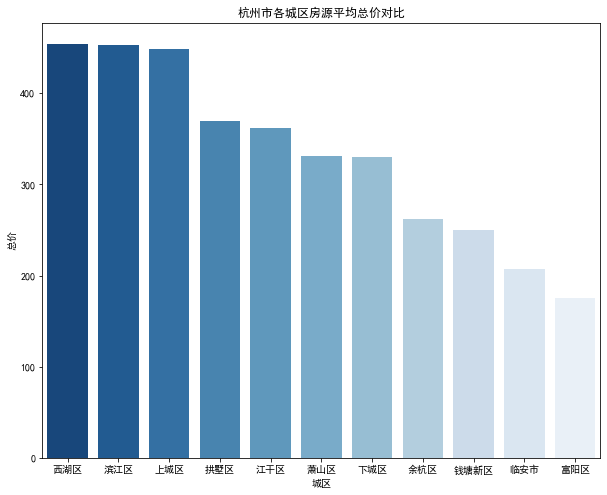

In [135]:
plt.figure(figsize=(10,8))
ax=sns.barplot(sum_area['地理位置'],sum_area['总价/万元'],palette='Blues_r')
ax.set_title('杭州市各城区房源平均总价对比')
ax.set_xlabel('城区')
ax.set_ylabel('总价')
plt.show()
# picture2=ax.get_figure()
# picture2.savefig('杭州各区房源数量对比.png')

In [138]:
pair2=[(row['地理位置'],round(row['总价/万元'],2)) for i ,row in sum_area.iterrows()]
map1=Map(init_opts=opts.InitOpts(theme='macarons',width='800px',height='400px'))
map1.add('杭州',pair2,'杭州',is_roam=False)
map1.set_series_opts(label_opts=opts.LabelOpts(is_show=False))
map1.set_global_opts(
    title_opts=opts.TitleOpts(title='杭州市各城区房源平均总价对比'),
    legend_opts=opts.LegendOpts(is_show=True),
    visualmap_opts=opts.VisualMapOpts(min_=sum_area['总价/万元'].min(),max_=sum_area['总价/万元'].max()),
    tooltip_opts=opts.TooltipOpts(formatter='{b}:{c}万元')
)
map1.render_notebook()

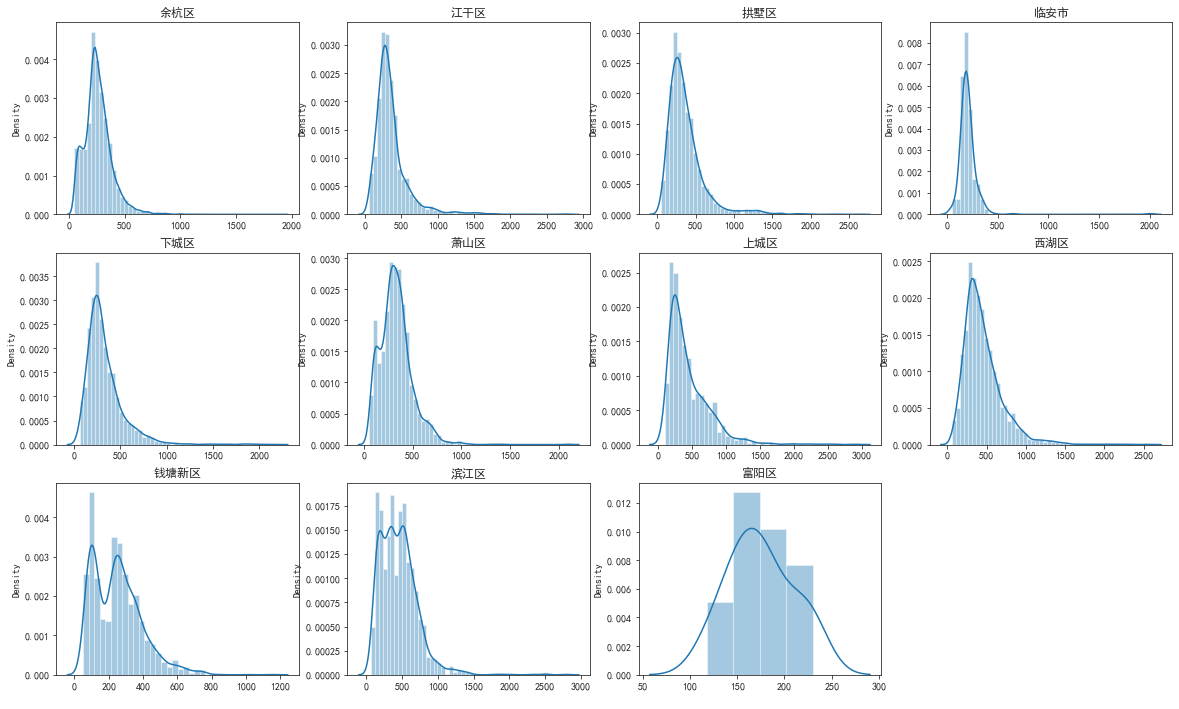

In [157]:
#地理位置与房价的关系
location=data['地理位置'].unique()
plt.figure(1,figsize=(20,12))
with sns.axes_style('ticks'):
    for i in range(len(location)):
        temp=data[data['地理位置']==location[i]]
        plt.subplot(3,4,i+1)
        plt.title(location[i])
        sns.distplot(temp['总价/万元'])
        plt.xlabel(' ')
plt.show()

In [150]:
#杭州市各地区房源每平方米单价对比
price_area=data.groupby('地理位置')['单价'].mean().sort_values(ascending=False).reset_index()

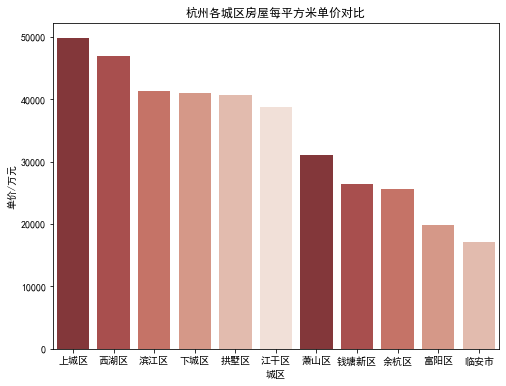

In [152]:
plt.figure(figsize=(8,6))
ax=sns.barplot(price_area['地理位置'],price_area['单价'],palette=sns.color_palette('Reds_r'),saturation=0.5)
ax.set_title('杭州各城区房屋每平方米单价对比')
ax.set_xlabel('城区')
ax.set_ylabel('单价/万元')
plt.show()

In [154]:
pair3=[(row['地理位置'],round(row['单价'],2)) for i,row in price_area.iterrows()]
map3=Map(init_opts=opts.InitOpts(width='800px',height='400px'))
map3.add('杭州',pair3,'杭州',is_roam=False)
map3.set_series_opts(label_opts=opts.LabelOpts(is_show=False))
map3.set_global_opts(
    title_opts=opts.TitleOpts(title='杭州市各城区房源每平方米单价对比'),
    legend_opts=opts.LegendOpts(is_show=True),
    visualmap_opts=opts.VisualMapOpts(min_=price_area['单价'].min(),max_=price_area['单价'].max()),
    tooltip_opts=opts.TooltipOpts(formatter='{b}:{c}万元')
)
map3.render_notebook()

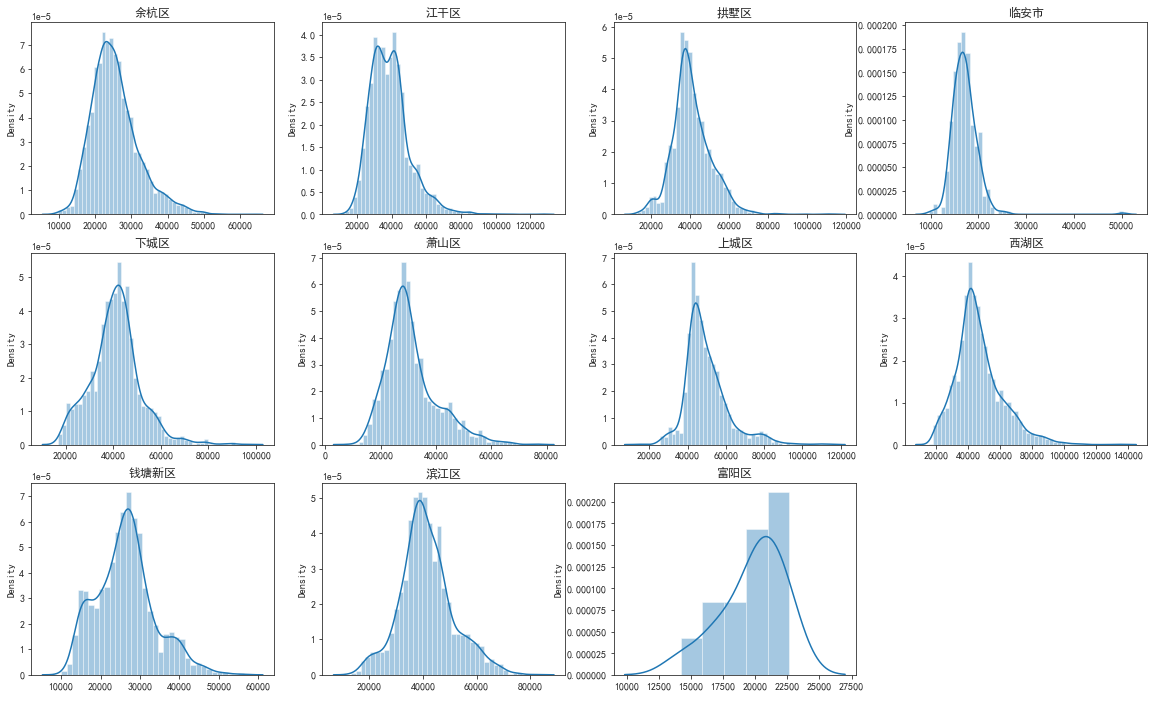

In [156]:
#地理位置与单价的关系
plt.figure(1,figsize=(20,12))
with sns.axes_style('ticks'):
    for i in range(len(location)):
        temp=data.loc[data['地理位置']==location[i]]
        plt.subplot(3,4,i+1)
        plt.title(location[i])
        sns.distplot(temp['单价'])
        plt.xlabel(' ')
plt.show()

In [158]:
#杭州市各城区房源关注热度对比
attention_area=data.groupby('地理位置')['关注'].sum().sort_values(ascending=False).reset_index()

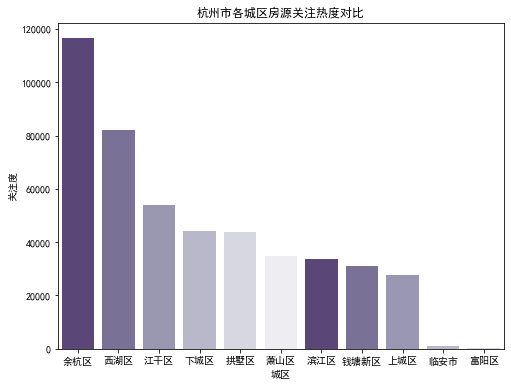

In [160]:
plt.figure(figsize=(8,6))
ax=sns.barplot(attention_area['地理位置'],attention_area['关注'],palette=sns.color_palette('Purples_r'),saturation=0.5)
ax.set_title('杭州市各城区房源关注热度对比')
ax.set_xlabel('城区')
ax.set_ylabel('关注度')
plt.show()

In [166]:
pair4=[(row['地理位置'],row['关注']) for i,row in attention_area.iterrows()]
map4=Map(init_opts=opts.InitOpts(theme='macarons',width='800px',height='400px'))
map4.add('杭州',pair4,'杭州',is_roam=False)
map4.set_series_opts(label_opts=opts.LabelOpts(is_show=False))
map4.set_global_opts(
    title_opts=opts.TitleOpts('杭州市各城区房源关注热度对比'),
    legend_opts=opts.LegendOpts(is_show=True),
    visualmap_opts=opts.VisualMapOpts(min_=attention_area['关注'].min(), max_=attention_area['关注'].max())
)
map4.render_notebook()

In [167]:
#不同户型的关注度
data['户型']=data['室数'].astype('str')+'室'+data['厅数'].astype('str')+'厅'

In [168]:
house_type_attention=data.groupby('户型')['关注'].sum().sort_values(ascending=False).reset_index()

In [169]:
bar1=Bar(init_opts=opts.InitOpts(theme='wonderland',width='600px',height='400px'))
bar1.add_xaxis(house_type_attention.head(10)['户型'].to_list())
bar1.add_yaxis('',house_type_attention.head(10)['关注'].to_list())
bar1.set_series_opts(label_opts=opts.LabelOpts(is_show=True))
bar1.set_global_opts(title_opts=opts.TitleOpts(title='关注度最高的户型top10'),xaxis_opts=opts.AxisOpts(axislabel_opts={'interval':'0'}))
bar1.render_notebook()

In [170]:
#不同朝向的关注度
oriteration_attention=data.groupby('朝向')['关注'].sum().sort_values(ascending=False).reset_index()

In [176]:
pair5=[(row['朝向'],row['关注']) for i,row in oriteration_attention.iterrows()]
pie1=Pie(init_opts=opts.InitOpts(theme='light',width='800px',height='400px'))
pie1.add('',pair5,radius=['35%','75%'])
pie1.set_global_opts(title_opts=opts.TitleOpts(title='不同朝向的关注度对比'),
                    legend_opts=opts.LegendOpts(is_show=True))
pie1.set_series_opts(label_opts=opts.LabelOpts(formatter='{b}:{c}%'))
pie1.render_notebook()

In [173]:
#不同产权的关注度
property_right_attention=data.groupby('产权')['关注'].sum().sort_values(ascending=False).reset_index()

In [177]:
pair6=[(row['产权'],row['关注']) for i,row in property_right_attention.iterrows()]
pie2=Pie(init_opts=opts.InitOpts(theme='macarons',width='800px',height='400px'))
pie2.add('',pair6,radius=['35%','75%'])
pie2.set_global_opts(title_opts=opts.TitleOpts(title='不同产权的关注度对比'),
                    legend_opts=opts.LegendOpts(is_show=True))
pie2.set_series_opts(label_opts=opts.LabelOpts(formatter='{b}: {d}%'))
pie2.render_notebook()

In [178]:
#不同楼层的关注度
location_attention=data.groupby('楼层位置')['关注'].sum().sort_values(ascending=False)

In [179]:
location_attention

楼层位置
高楼层    170893
中楼层    152497
低楼层    146405
Name: 关注, dtype: int64